## 3. Analyse van de ideologische koers

In dit notebook voeren we voor een hoofdcomponentenanalyse op de data van het Manifesto Project uit. Hiermee plaatsen we alle politieke partijen uit vijftien Westerse landen op één gemeenschappelijke schaal van links tot rechts. Daarmee volgen we het voorbeeld van de [New York Times](https://www.nytimes.com/interactive/2019/06/26/opinion/sunday/republican-platform-far-right.html), die in 2019 op een vergelijkbare manier de koers van Republikeinse partij onderzocht. 

In [1]:
import datetime
import numpy as np
import pandas as pd

from collections import Counter
from csaps import csaps

import prince
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


def smooth(x, y, smooth=0.95):
    xs = np.linspace(x[0], x[-1], 150)
    ys = csaps(x, y, xs, smooth=smooth)
    return xs, ys

%config InlineBackend.figure_format='retina'

mpl.style.use('../groene.mpl')

In [2]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=100):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=100, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height 
    deltas = [] 
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

In [3]:
selected_cols = ['101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '201', '202', '203', '204', '301', '302', '303', '304', '305', '401', '402', '403', '404', '405', '406', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '501', '502', '503', '504', '505', '506', '507', '601', '602', '603', '604', '605', '606', '607', '608', '701', '702', '703', '704', '705', '706']

coded_data = pd.read_csv('data/manifestos_nl_2023_coded_sents.csv')

coded_data = coded_data[coded_data.code != 0]
coded_data['year'] = coded_data.date.apply(lambda x: int(x[:4]))

In [4]:
rows = []
for (party, date, country), party_date_df in coded_data.groupby(['party', 'date', 'country']):
    code_counts = Counter(party_date_df.code)
    code_counts_vec = np.array([code_counts[int(col)] for col in selected_cols])
    code_counts_vec_norm = (code_counts_vec / np.sum(code_counts_vec)) * 100
    rows.append([party, date, country] + list(code_counts_vec_norm))

data_2023 = pd.DataFrame(rows, columns = ['party', 'date', 'country'] + selected_cols)
data_2023.sort_values('date').head(5)

,party,date,country,101,102,103,104,105,106,107,...,605,606,607,608,701,702,703,704,705,706
0,50PLUS,2023-10-01,Netherlands,0.000000,0.0,0.000000,1.119403,1.119403,0.373134,2.238806,...,5.970149,1.492537,0.000000,1.119403,1.492537,0.0,0.373134,0.373134,0.000000,1.119403
15,SP,2023-10-01,Netherlands,0.403769,0.0,0.000000,0.269179,0.942127,0.672948,1.345895,...,5.248991,1.615074,0.000000,1.076716,4.441454,0.0,0.403769,0.134590,0.403769,0.134590
14,SGP,2023-10-01,Netherlands,0.000000,0.0,0.000000,2.539683,0.476190,0.158730,3.015873,...,5.079365,2.857143,0.158730,0.634921,1.269841,0.0,5.714286,0.000000,0.476190,0.158730
13,PvdD,2023-10-01,Netherlands,0.032776,0.0,0.131105,0.098328,0.852180,0.163881,2.196001,...,2.064897,0.622747,0.131105,0.065552,1.278269,0.0,1.343822,0.032776,0.098328,0.065552
12,PVV,2023-10-01,Netherlands,0.000000,0.0,0.000000,1.246106,0.311526,0.155763,0.934579,...,9.501558,0.000000,0.155763,4.205607,0.623053,0.0,5.451713,0.311526,0.000000,0.000000


In [5]:
mpd_data = pd.read_csv('data/MPDataset_MPDS2023a.csv', low_memory=False)

SELECTED_COUNTRIES = ['United States', 'Canada', 'Spain', 'Belgium', 'Netherlands', 'France', 'Denmark',
 'Italy', 'Austria', 'Germany', 'Switzerland', 'Sweden', 'United Kingdom', 'Portugal', 'Finland']

mpd_data = mpd_data[mpd_data.countryname.isin(SELECTED_COUNTRIES)]
mpd_data.loc[mpd_data['partyname'] ==  'Together', 'partyabbrev'] = 'Bij1'
mpd_data.loc[mpd_data['partyname'] ==  'Together', 'partyabbrev'] = 'Bij1'

mpd_data['date'] = pd.to_datetime(mpd_data.edate, dayfirst=True)
mpd_data = mpd_data[mpd_data.date > datetime.datetime(2000,1,1)]

mpd_data = mpd_data[['partyabbrev','date', 'countryname'] + ['per{}'.format(col) for col in selected_cols]]

mpd_data.columns = ['party', 'date', 'country'] + selected_cols
mpd_data.loc[mpd_data['party'] == 'D’66', 'party'] = 'D66'
mpd_data.loc[mpd_data['party'] == 'FvD', 'party'] = 'FVD'

mpd_data.dropna(inplace=True, subset=selected_cols)

mpd_data.head(5)

,party,date,country,101,102,103,104,105,106,107,...,605,606,607,608,701,702,703,704,705,706
99,MP,2002-09-15,Sweden,0.000,0.0,0.0,0.000,3.106,0.621,8.075,...,0.000,0.000,0.000,0.0,1.242,0.0,0.000,0.000,0.000,8.075
100,V,2002-09-15,Sweden,0.000,0.0,0.0,0.000,0.000,0.491,5.897,...,0.246,0.737,0.000,0.0,7.862,0.0,0.000,0.491,3.440,20.393
101,SAP,2002-09-15,Sweden,0.733,0.0,0.0,0.000,0.000,0.733,6.593,...,6.593,4.396,0.733,0.0,5.495,0.0,0.000,0.000,1.465,8.425
102,FP,2002-09-15,Sweden,0.000,0.0,0.0,0.932,0.000,0.233,6.061,...,3.030,2.331,0.000,0.0,0.932,0.0,0.000,0.000,1.632,7.459
103,Kd,2002-09-15,Sweden,0.000,0.0,0.0,0.000,0.000,0.301,3.916,...,6.325,0.000,0.000,0.0,1.807,0.0,0.904,0.602,0.301,5.422


In [6]:
data = pd.concat([data_2023, 
                  mpd_data])
data['year'] = data['date'].astype(str).apply(lambda x: int(x[:4]))
data['date'] = pd.to_datetime(data['date'])

In [7]:
ca = prince.PCA(
    n_components=2,
    n_iter=10,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
ca = ca.fit(data[selected_cols])

In [8]:
data['pc_1'] = ca.row_coordinates(data[selected_cols])[0]
data['pc_2'] = ca.row_coordinates(data[selected_cols])[1]

### Eerst: in hoeverre komt onze analyse overeen met die van de [New York Times in 2019](https://www.nytimes.com/interactive/2019/06/26/opinion/sunday/republican-platform-far-right.html)?

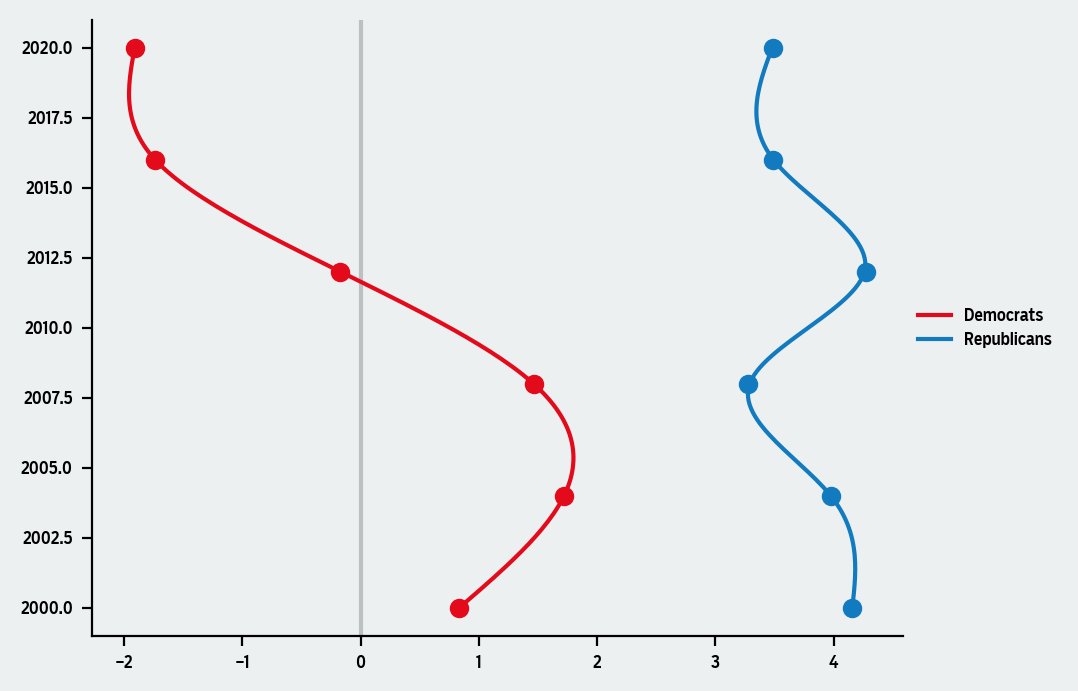

In [9]:
path = data[(data.country == 'United States')]

plt.figure(figsize=(5.229, 4))


for party, group_df in path.sort_values('year').groupby('party'):
    x = list(group_df.year.values)
    y = list(group_df['pc_1'].values * -1)
    if len(group_df) > 1:
        x_smooth, y_smooth = smooth(x,y)
        plt.plot(y_smooth, x_smooth, label=party)
    else:
        plt.plot(y,x, label=party)
    plt.scatter(y,x)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.axvline(0, zorder=-1, alpha=0.2, color='black')

## Dan: hoe verschoven de Nederlandse partijen?

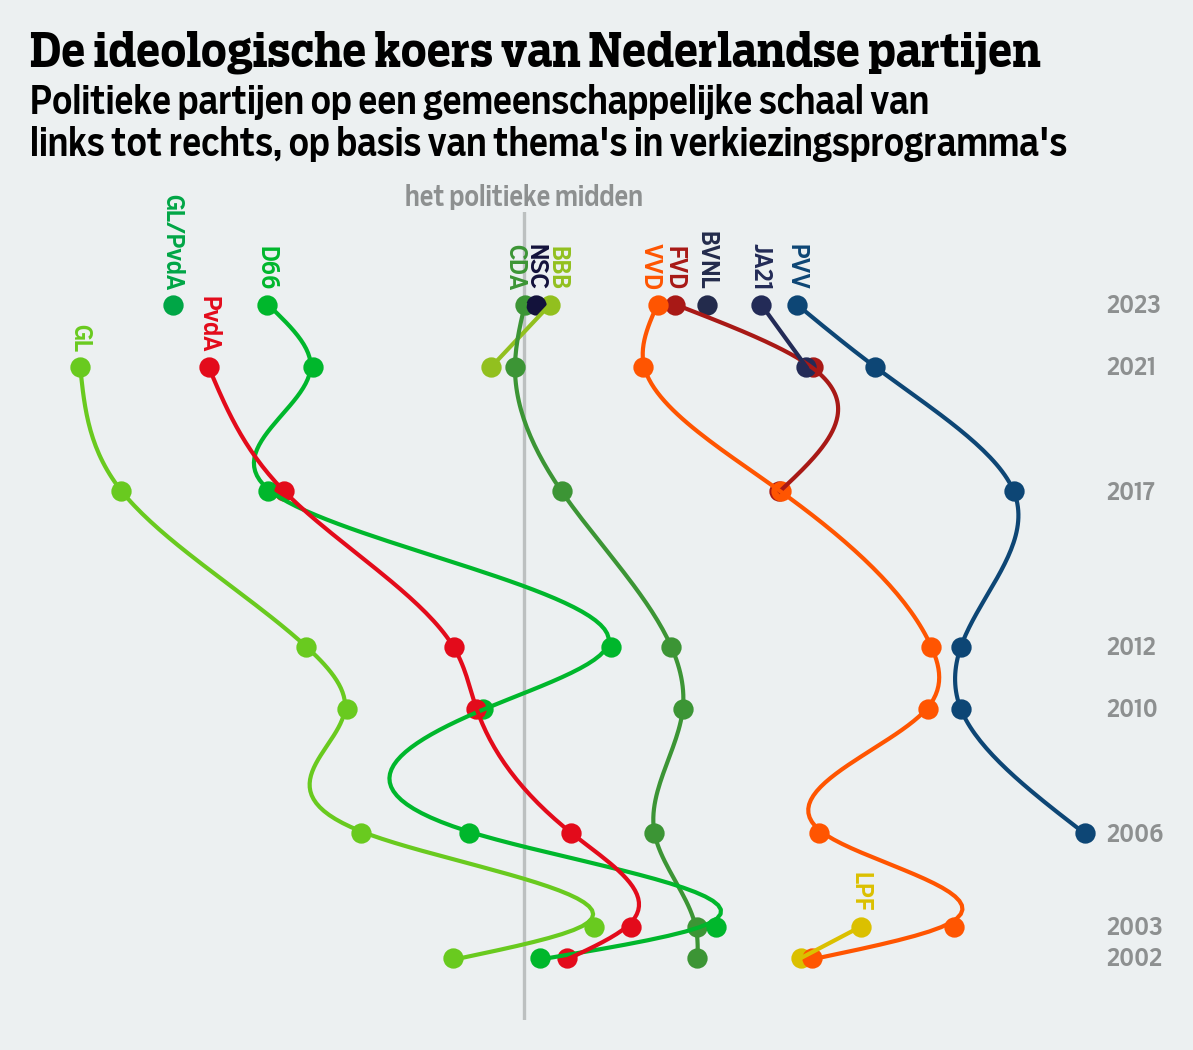

In [10]:
party2col = {
  "PvdA": "#e30b1b",
  "CDA": "#3c9535",
  "VVD": "#ff5501",
  "SP": "#c71617",
  "D66": "#00b72c",
  "GL": "#69ca1f",
  "PVV": "#0d4675",
  "CU": "#00a0ed",
  "SGP": "#f39307",
  "PvdD": "#007124",
  "Overig": "#7f7b7a",
  "DENK": "#BE4F00",
  "FVD": "#a81916",
  "NSC": "#13123b",
  "GL/PvdA": "#00a646",
  "BBB": "#92c01f",
  "JA21": "#232b57",
  "BVNL": "#232b4c",
  "LPF": "#dbc000",
  "Volt": "#502279",
  "50PLUS": "#500051",
  "LN": "#f3e73a",
  "Bij1": "#f3e73a"
}

path = data[(data.country == 'Netherlands')]

fig, ax = plt.subplots(figsize=(5.299, 3.5), dpi=150)

party_tups = dict()
for party, group_df in path[path.party.isin(['PVV', 'JA21', 'NSC', 'GL/PvdA', 'BBB', 'FVD', 'BVNL', 'CDA',
                                             'LPF', 'D66',
                                             'VVD', 'GL', 'PvdA'])].sort_values('year').groupby('party'):
    
    if party in ['GL', 'GL/PvdA', 'PvdA']:
        alpha = 1
    else:
        alpha = 1
    x = list(group_df.year.values)
    y = list(group_df['pc_1'].values * -1)
    color = party2col[party] if party in party2col else party2col['Overig']
    if len(group_df) > 1:
        x_smooth, y_smooth = smooth(x,y)
        plt.plot(y_smooth, x_smooth, label=party, color=color, alpha=alpha, linewidth=1)
    else:
        plt.plot(y,x, color=color, label=party, alpha=alpha)
    plt.scatter(y,x, color=color, s=15, alpha=alpha)
    if party == 'VVD':
        for i, f in enumerate(x):
           
            plt.text(4.4, x[i] , x[i], fontsize=6, ha='left', va='center' , alpha=0.4)
    
    if party == 'CDA':
        add = -0.07
    elif party == 'BBB':
        add = 0.06
    elif party == 'VVD':
        add = -0.05
    else:
        add = 0
    plt.text(y[-1] + add, x[-1] + 0.5, party, fontsize=6, 
             va='bottom', ha='center', rotation=-90, color=color, alpha=alpha)

plt.axvline(0, ymax=1.2, zorder=-1, alpha=0.2, color='black', linewidth=0.8)
plt.text(0, 2026.2, 'het politieke midden', ha='center', fontsize=6.5, alpha=0.4)
plt.ylim(2000, 2026)
sns.despine(left=True, bottom=True)

plt.title('De ideologische koers van Nederlandse partijen', fontsize=11, x=0, ha='left', y=1.15)
plt.text(0,1.07,"Politieke partijen op een gemeenschappelijke schaal van\nlinks tot rechts, op basis van thema's in verkiezingsprogramma's ",
           transform=plt.gca().transAxes, fontsize=9)

plt.axis('off')

set_size(fig, (3.97425, 3.5))

plt.savefig('figures/1.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/1.png', dpi=300, bbox_inches='tight')

## Welke onderwerpen trekken een partij naar links of rechts?

In [11]:
code_descriptions = pd.read_csv('https://manifesto-project.wzb.eu/down/data/2020a/codebooks/codebook_categories_MPDS2020a.csv')
code_descriptions = code_descriptions[code_descriptions.type == 'main']
code_descriptions['code'] = code_descriptions.code.apply(lambda x: str(x)[:3])

code2description = dict(zip(code_descriptions.code, code_descriptions.title))

In [12]:
eng2dutch = {
    'Law and Order: Positive': 'Law and order',
    'Free Market Economy': 'Vrijemarkteconomie',
    'National Way of Life: Positive': 'Nationalisme',
    'Welfare State Limitation': 'Inperking verzorgingsstaat',
    'Military: Positive': 'Leger: positief',
    'Economic Orthodoxy': 'Orthodoxe economie',
    'Multiculturalism: Negative': 'Multiculturalisme: negatief',
    'Incentives: Positive': 'Stimulansen',
    'Governmental and Administrative Efficiency': 'Efficientie overheid',
    'Traditional Morality: Positive': 'Traditionele normen',
    'Market Regulation': 'Marktregulering',
    'Environmental Protection': 'Milieubescherming',
    'Controlled Economy': 'Gecontroleerde economie',
    'Nationalisation': 'Nationalisering',
    'Anti-Imperialism': 'Anti-imperialisme',
    'Anti-Growth Economy: Positive': 'Anti-groeieconomie',
    'Military: Negative': 'Leger: negatief',
    'Traditional Morality: Negative': 'Progressieve normen',
    'Labour Groups: Positive': 'Arbeidersgroepen',
    'Equality: Positive': 'Gelijkwaardigheid'
}

(-0.7356360176583063,
 0.6304610967081805,
 -1.0600000000000003,
 20.060000000000002)

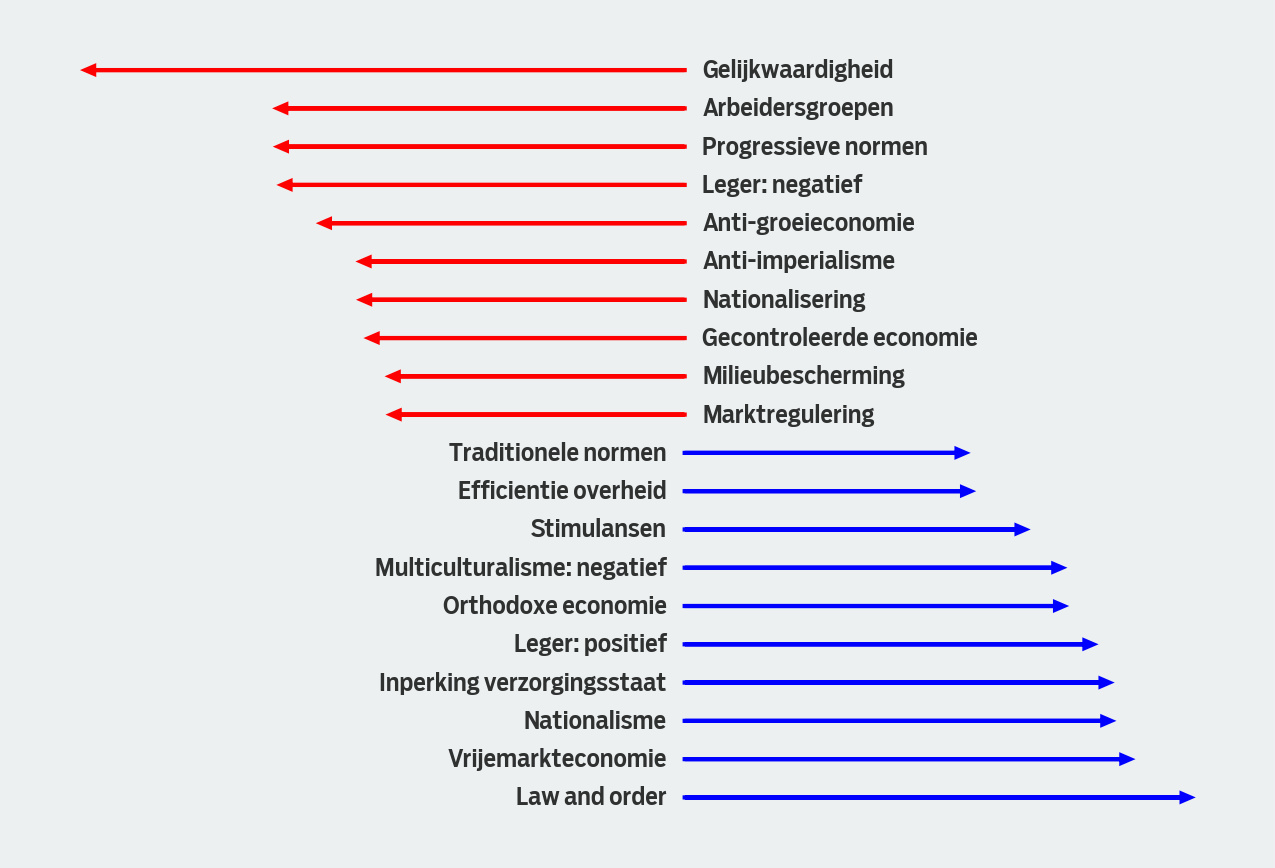

In [13]:
most_left = pd.DataFrame(ca.column_correlations[0].sort_values().head(10)).reset_index()
most_right = pd.DataFrame(ca.column_correlations[0].sort_values(ascending=False).head(10)).reset_index().sort_values(0)

combined = pd.concat([most_left, most_right])
combined.columns = ['code', 'dim']
combined['label'] = combined.code.apply(lambda x: code2description[x])

categories = combined.label
values = combined.dim * -1

fig, ax = plt.subplots(figsize=(5.229, 3.5), dpi=150)

for i, (category, value) in enumerate(zip(categories, values)):
    pad = 0.02
    if value > 0:
        color = 'blue'
        ha = 'right'  
    else:
        color = 'red'
        ha = 'left'
        pad = pad * -1
    ax.arrow(0, i, value, 0, head_width=0.2, head_length=0.01, fc=color, ec=color)
    
    ax.text(0 - pad, i, eng2dutch[category], ha=ha, va='center', alpha=0.8)

ax.set_yticks(range(len(categories)))
ax.set_yticklabels(categories)

ax.set_xlabel('Values')

plt.axis('off')

## Welke bewegingen zien we op specifieke onderwerpen?

In [14]:
subject = 'Migratie'

code2issue = pd.read_csv('https://raw.githubusercontent.com/vanatteveldt/2023-manifestos-nl/main/data/raw/cmp_topics.csv')

ca = prince.PCA(
    n_components=2,
    n_iter=10,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
ca = ca.fit(data[[str(x) for x in code2issue[code2issue.label == subject].cmp.values]])


In [15]:
data['pc_1'] = ca.row_coordinates(data[selected_cols])[0] 
data['pc_2'] = ca.row_coordinates(data[selected_cols])[1]

(-1.1064783336401283, 8.734543201370142, 2000.0, 2026.0)

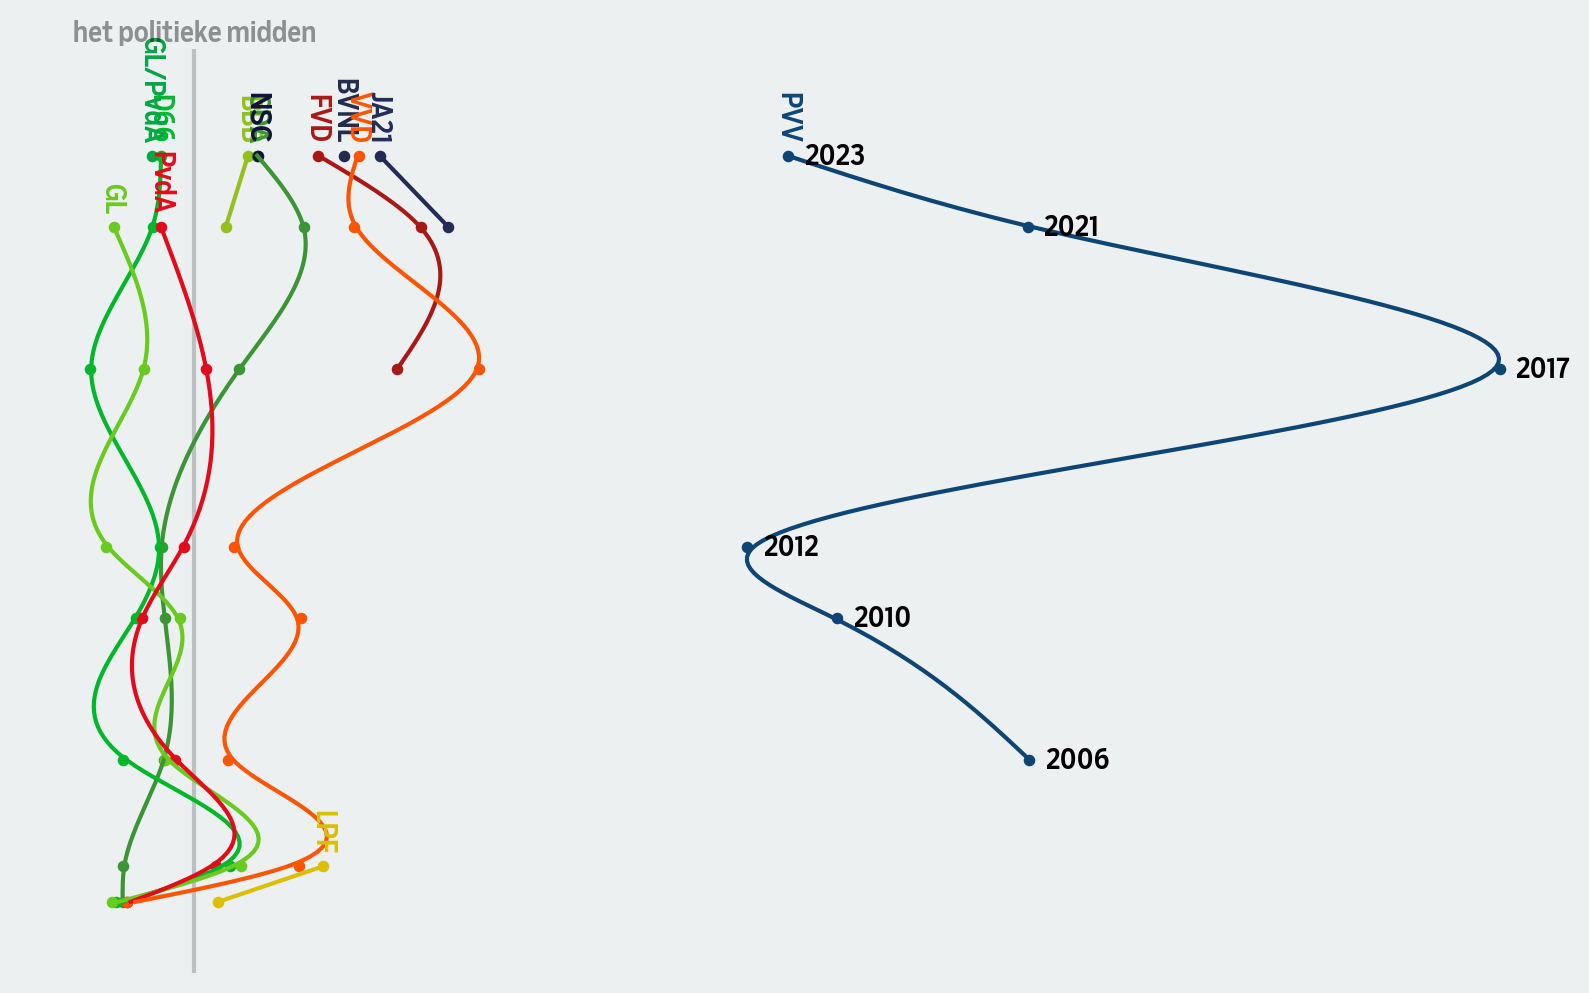

In [16]:
path = data[(data.country == 'Netherlands')]

plt.figure(figsize=(10, 6), dpi=100)


for party, group_df in path[path.party.isin(['PVV', 'JA21', 'NSC', 'GL/PvdA', 'BBB', 'FVD', 'BVNL', 'CDA',
                                             'LPF', 'D66',
                                             'VVD', 'GL', 'PvdA'])].sort_values('year').groupby('party'):
    
    if party in ['GL', 'GL/PvdA', 'PvdA']:
        alpha = 1
    else:
        alpha = 1
    x = list(group_df.year.values)
    y = list(group_df['pc_1'].values)
    color = party2col[party] if party in party2col else party2col['Overig']
    if len(group_df) > 1:
        x_smooth, y_smooth = smooth(x,y)
        plt.plot(y_smooth, x_smooth, label=party, color=color, alpha=alpha)
    else:
        plt.plot(y,x, color=color, label=party, alpha=alpha)
    plt.scatter(y,x, color=color, s=10, alpha=alpha)
    if party == 'PVV':
        for i, f in enumerate(x):
            plt.text(y[i]+0.1, x[i], x[i], fontsize=10, ha='left', va='center' ,alpha=alpha)
    
    plt.text(y[-1], x[-1] + 0.35, party, fontsize=10, va='bottom', ha='center', rotation=-90, color=color, alpha=alpha)
plt.axvline(0, ymax=1.2, zorder=-1, alpha=0.2, color='black')
plt.text(0, 2026.2, 'het politieke midden', ha='center', fontsize=10, alpha=0.4)
plt.ylim(2000, 2026)
sns.despine(left=True, bottom=True)
plt.axis('off')